Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

In [1]:
from typing import Callable, Tuple
from warnings import filterwarnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from grid_search_arima import GridSearch

In [2]:
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=ValueWarning)

In [10]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [4]:
df = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col="year")

In [5]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [6]:
df.tail()

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [7]:
df.size

62

In [8]:
X_train = df.iloc[:-3]["GDP (current US$)"]
X_test = df.iloc[-3:]["GDP (current US$)"]

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

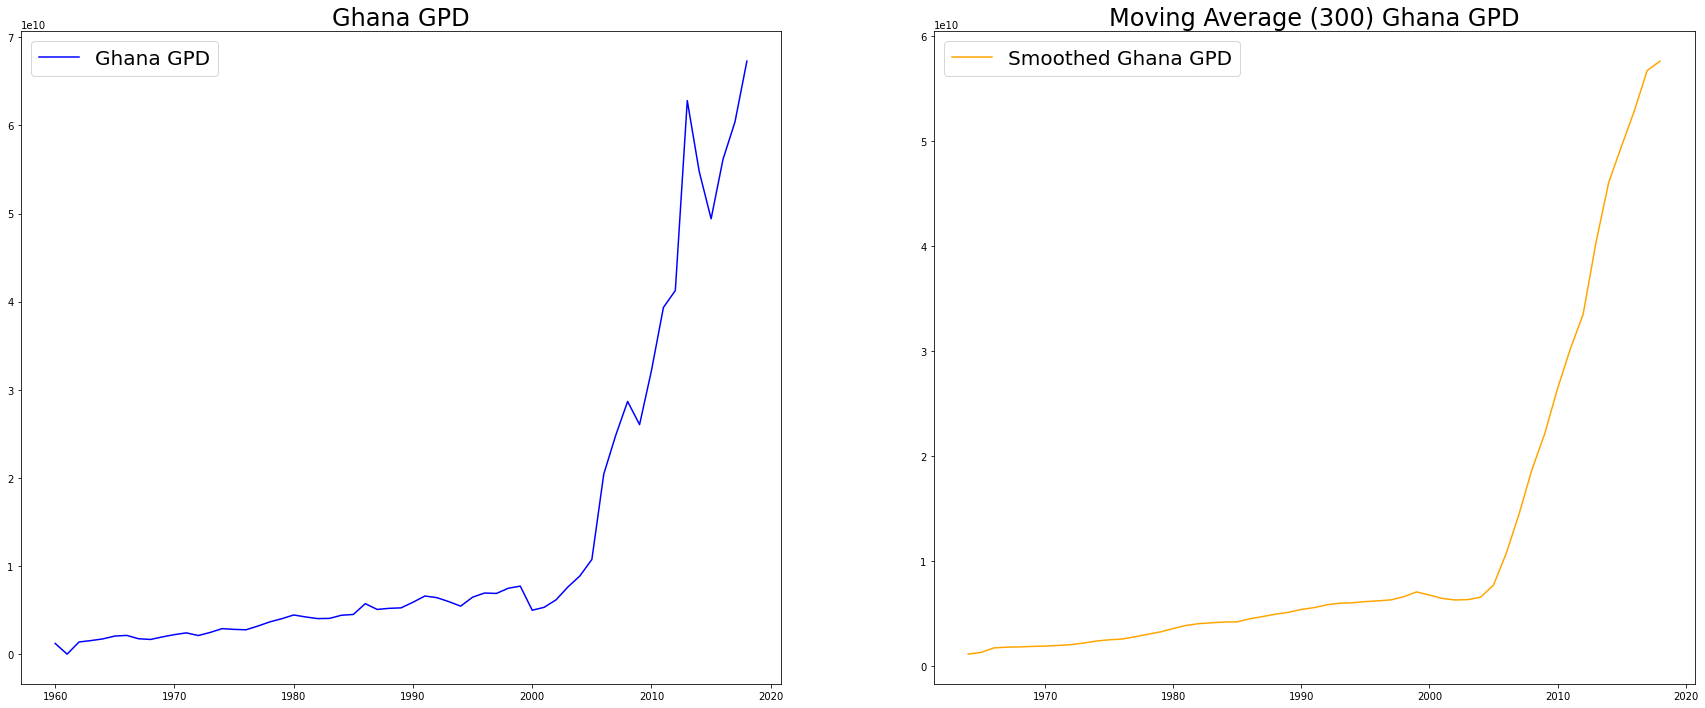

In [11]:
fig, ax = plt.subplots(1, 2)

# Окно в 5 лет (Window = 5)
ax[0].plot(X_train, color="blue", label="Ghana GPD")
ax[0].set_title("Ghana GPD", size=24)
ax[0].legend()

ax[1].plot(
    X_train.rolling(window=5).mean(),
    color="orange",
    label="Smoothed Ghana GPD",
)
ax[1].set_title("Moving Average (300) Ghana GPD", size=24)
ax[1].legend()

plt.show()

Оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. Выберите парамeтры p и q по коррелограммам ACF и PACF. Также постройте модель с параметрами, ближайшими к p и q, и сравните коэффициент AIC или подберите наилучшие параметры с помощью pmdarima, как в скринкасте.

In [12]:
def is_stationary(series: pd.Series) -> bool:
    """
    Определяет, является ли ряд стационарным.

    Args:
        series: временной ряд

    Returns:
        True, если ряд является стационарным, иначе False
    """
    test = adfuller(series)
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    return test[0] <= test[4]["5%"]

In [13]:
s1, s2 = ("", "") if is_stationary(X_train) else ("не", "I")
print(f"Ряд {s1}стационарный, поэтому нам нужна модель AR{s2}MA.")

adf:  0.65290669748854
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарный, поэтому нам нужна модель ARIMA.


In [14]:
series = X_train
d = 1

while not is_stationary(series := series.diff(1).dropna()):
    d += 1

print(f"\nОптимальное значение параметра d: {d}")

adf:  -1.6702483038320752
p-value:  0.44650293297139043
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
adf:  -2.640869056128489
p-value:  0.08484116917837686
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
adf:  -4.779623784828548
p-value:  5.948327640224507e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Оптимальное значение параметра d: 3


In [15]:
def plot_correlogram(
    series: pd.Series, plot_function: Callable, ax: matplotlib.axes.Axes
) -> None:
    """
    Строит коррелограмму acf или pacf для временного ряда.

    Args:
        series: временной ряд
        corr_function: функция построения коррелограммы
        ax: оси, на которых нужно построить коррелограмму

    Raises:
        ValueError, если функция построения коррелограммы неправильная
    """
    if plot_function.__name__ == "plot_acf":
        title = "Autocorrelation"
    elif plot_function.__name__ == "plot_pacf":
        title = "Partial autocorrelation"
    else:
        raise ValueError("Incorrect plot function")
    
    lags = len(series) // 2 - 1
    plot_function(series, lags=lags, ax=ax)
    ax.set_title(title)
    ax.xaxis.set_ticks(np.arange(0, lags + 1, 1))
    ax.yaxis.set_ticks(np.arange(-1.0, 1.0, 0.1))
    ax.grid()

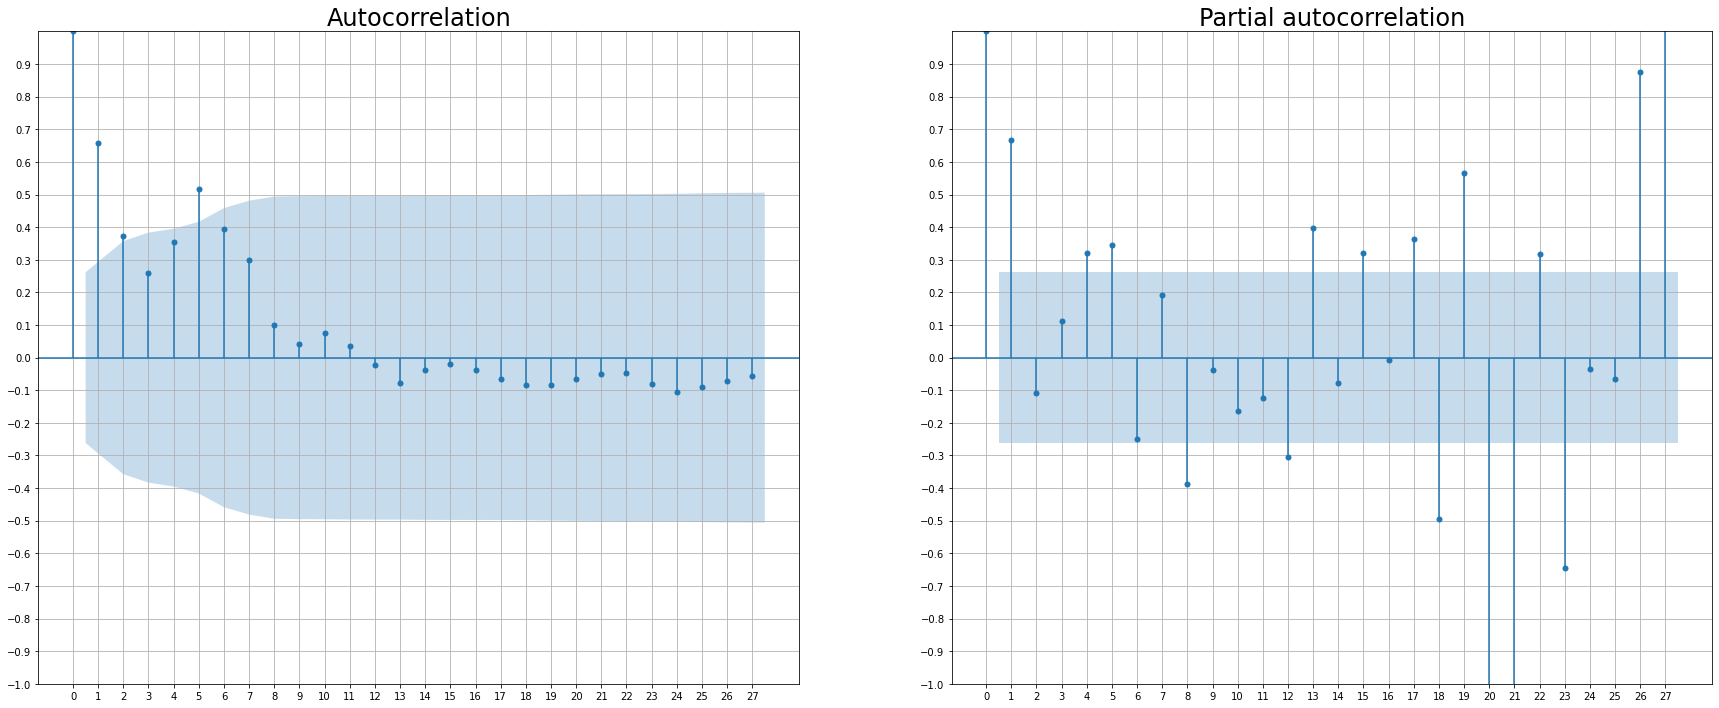

In [16]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(X_train.diff(3).dropna(), plot_acf, ax[0])
plot_correlogram(X_train.diff(3).dropna(), plot_pacf, ax[1])
plt.show()

Как мы видим из графиков, оптимальное значение параметра *p* – 2, а *q* – 1.

Подберём наилучшие значения параметров вручную по сетке.

In [17]:
param_grid = {
    "p": range(0, 4),
    "q": range(0, 3),
}

In [18]:
grid_search = GridSearch(ARIMA, param_grid)

In [19]:
grid_search

GridSearch(estimator=<class 'statsmodels.tsa.arima.model.ARIMA'>, param_grid={'p': range(0, 4), 'q': range(0, 3)})

In [20]:
grid_search.fit(X_train, d=d)

12it [00:01,  9.62it/s]


In [21]:
print(grid_search.results_)

{'param_p': [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3], 'param_q': [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2], 'score': [2734.955598697367, inf, inf, 2707.1916044956065, 2670.9100753144676, inf, 2679.049715040537, 2659.230811357535, inf, 2676.8831665707057, 2660.791106442377, inf], 'params': [{'p': 0, 'q': 0, 'd': 3}, {'p': 0, 'q': 1, 'd': 3}, {'p': 0, 'q': 2, 'd': 3}, {'p': 1, 'q': 0, 'd': 3}, {'p': 1, 'q': 1, 'd': 3}, {'p': 1, 'q': 2, 'd': 3}, {'p': 2, 'q': 0, 'd': 3}, {'p': 2, 'q': 1, 'd': 3}, {'p': 2, 'q': 2, 'd': 3}, {'p': 3, 'q': 0, 'd': 3}, {'p': 3, 'q': 1, 'd': 3}, {'p': 3, 'q': 2, 'd': 3}]}


In [22]:
grid_search.best_score_

2659.230811357535

In [23]:
grid_search.best_params_

(2, 3, 1)

Подбираем наилучшие значения параметров автоматически с помощью pmdarima.

In [24]:
smodel = auto_arima(
    X_train,
    d=3,
    test='adf',
    seasonal=False,
    stationary=False,
    n_jobs=-1,
    error_action="ignore",
    trace=True,
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.08 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.08 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.05 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.178 seconds


In [25]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 29 Dec 2022   AIC                           2659.231
Time:                        05:47:50   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+56. Standard errors may be unstable.
"""

Постройте модель с наилучшими параметрами и выполните предсказание на три года.

In [41]:
pred = grid_search.predict(X_test)
forecast = grid_search.get_forecast(X_test).conf_int(alpha=0.05)

In [42]:
pred

2019-01-01    7.368591e+10
2020-01-01    7.954567e+10
2021-01-01    8.633936e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [43]:
forecast.head()

,lower GDP (current US$),upper GDP (current US$)
2019-01-01,6.269386e+10,8.467796e+10
2020-01-01,6.163504e+10,9.745630e+10
2021-01-01,6.065904e+10,1.120197e+11


Отобразите результат графически.

In [40]:
def plot_forecast(
    true: pd.Series,
    pred: pd.Series,
    forecast: pd.DataFrame,
    ax: matplotlib.axes.Axes,
    full: bool = True
) -> None:
    """
    Строит график реальных значений, предсказаний и прогноза временного ряда.

    Args:
        y_true: реальные значения временного ряда
        y_pred: предсказания модели для временного ряда
        forecast: прогноз модели для временного ряда
        ax: оси, на которых нужно построить график
        full: если False, то график строится только для тестовой выборки
    """
    if not full:
        true = true[:-3]

    ax.plot(true, color="blue", label="Actuals", alpha=0.4)
    ax.plot(pred, color="red", linestyle="-", label="Out of Sample Fit")

    ax.plot(
        forecast.iloc[:, 0],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.4,
    )

    ax.plot(forecast.iloc[:, 1], color="green", linestyle="--", alpha=0.4)
    ax.set_title("Full Model Fit" if full else "Out of Sample Fit")
    ax.legend()

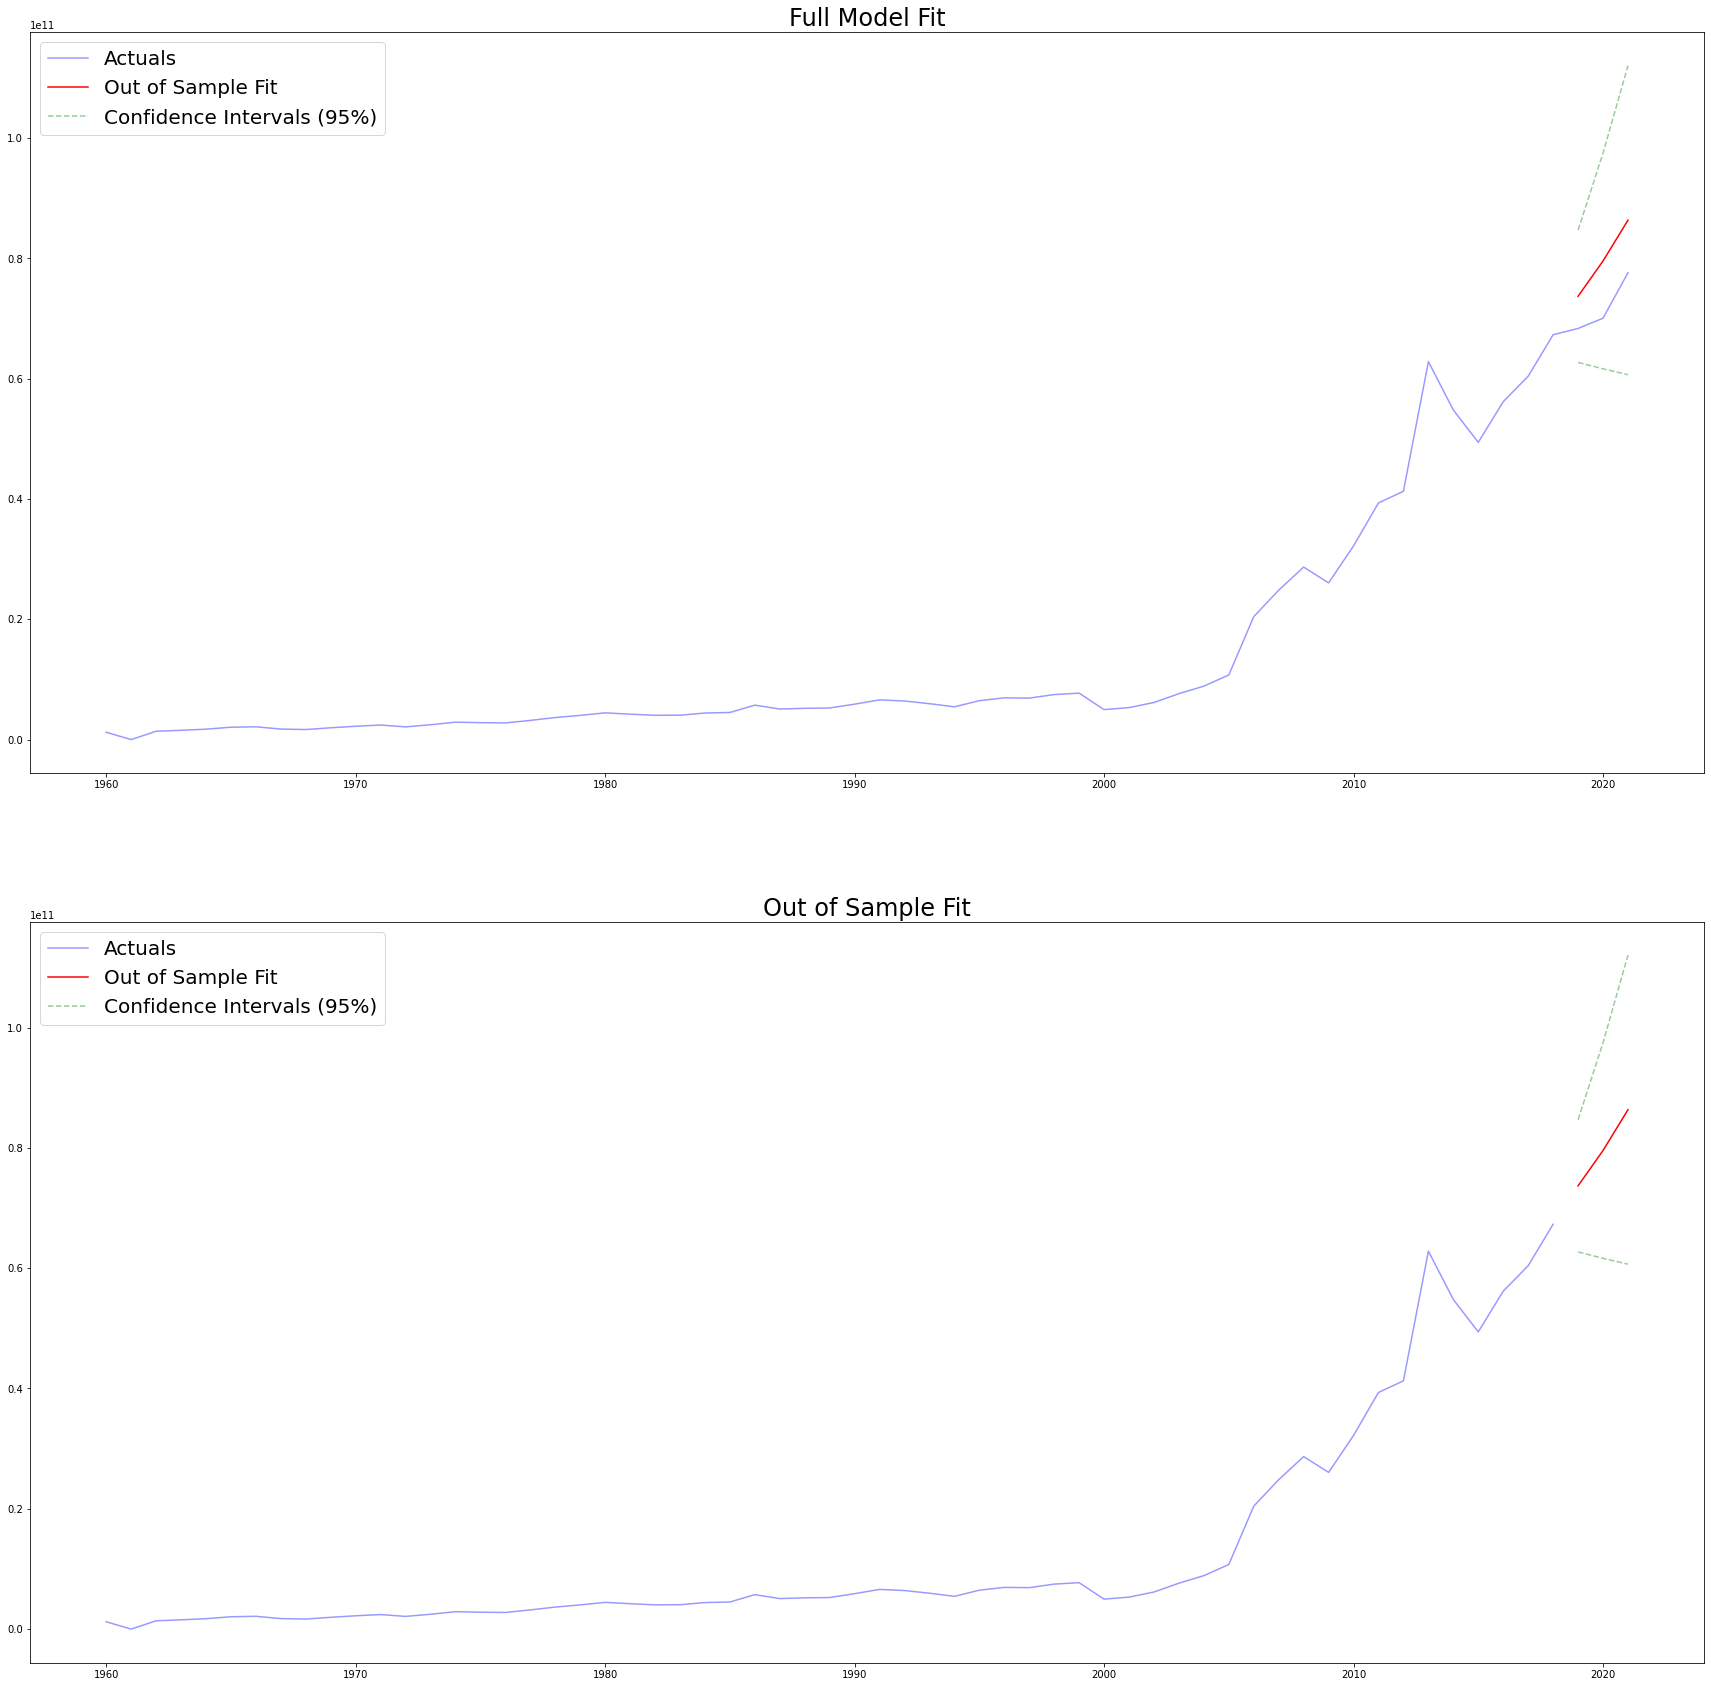

In [44]:
plt.rcParams["figure.figsize"] = 30, 30
fig, ax = plt.subplots(2, 1)
plot_forecast(df["GDP (current US$)"], pred, forecast, ax[0])
plot_forecast(df["GDP (current US$)"], pred, forecast, ax[1], full=False)
plt.show()